# Data Visualization: Curated_to_Dashboard

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import *

In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

#### Using the curated zone to view the number of tables available.

In [ ]:
%sql

USE curated;
SHOW TABLES;

database,tableName,isTemporary
curated,categorybyorders,false
curated,ordervolandrevenue,false
curated,revbydemography,false
curated,revenuebycategory,false
curated,revenueforecast,false
curated,rfm,false
curated,spendbyage,false
curated,statuscount,false


## Representing the data from the Curated tables for Insights.

#### 1. Management wants to drill down the order volume and revenue generated by year, month, categories

In [ ]:
df = spark.read.table("curated.ordervolandrevenue")

In [ ]:
df = df.withColumn('Year_Month', to_date(col('Year_Month'), 'yyyy-MM'))

In [ ]:
from pyspark.sql.functions import sum as sum_

# Group by Year_Month_Date and Category, then sum Total_Order
grouped_orders = df.groupBy('Year_Month', 'Category').agg(sum_('Total_Orders').alias('Total_Orders'))

# Convert to pandas DataFrame
grouped_orders_pd = grouped_orders.toPandas()

# Pivot the DataFrame for plotting
pivot_order = grouped_orders_pd.pivot(index='Year_Month', columns='Category', values='Total_Orders').fillna(0)

<Figure size 1008x504 with 0 Axes>

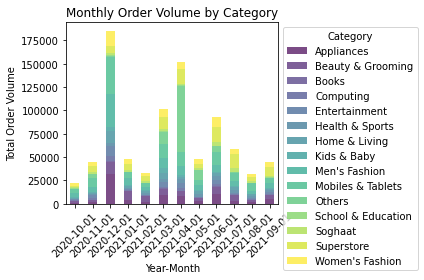

In [ ]:
# Plot the stacked bar chart for Total_Order
plt.figure(figsize=(14, 7))
pivot_order.plot(kind='bar', stacked=True, colormap='viridis', alpha=0.7)
plt.title('Monthly Order Volume by Category')
plt.xlabel('Year-Month')
plt.ylabel('Total Order Volume')
# Adjust the legend position
plt.legend(title='Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

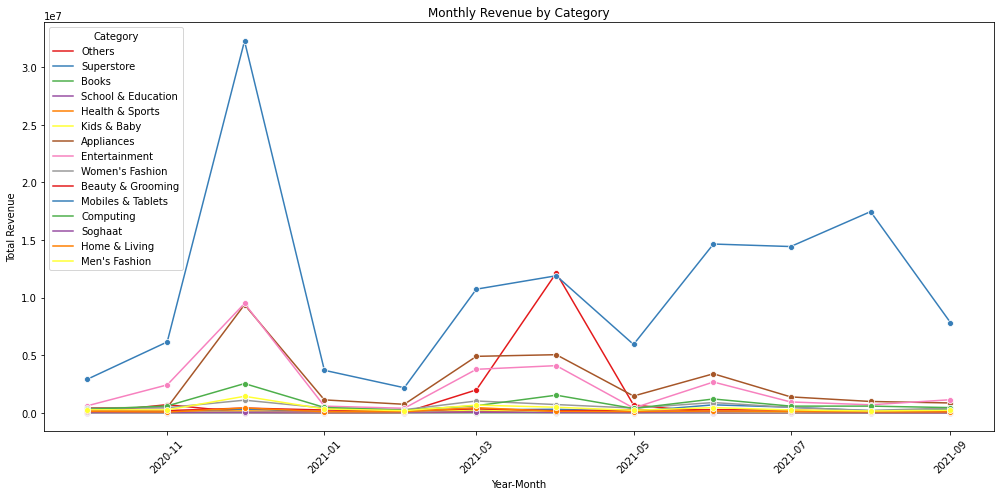

In [ ]:
# Plot the line chart for Total_Revenue
plt.figure(figsize=(14, 7))
sns.lineplot(data=df.toPandas(), x='Year_Month', y='Total_Revenue', hue='Category', marker='o', palette='Set1')
plt.title('Monthly Revenue by Category')
plt.xlabel('Year-Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 2. Revenue growth by categories from previous month to this month.

In [ ]:
df = spark.read.table("curated.revenuebycategory")

In [ ]:
df = df.withColumn('Year-Month', to_date(col('Year-Month'), 'yyyy-MM'))

In [ ]:
# Group by Year_Month_Date and Category, then sum Total_Revenue and Previous_Revenue
grouped_df = df.groupBy('Year-Month', 'Category').agg(
    sum('Total_Revenue').alias('Total_Revenue'),
    sum('Previous_Revenue').alias('Previous_Revenue'),
    sum('Revenue_Growth').alias('Revenue_Growth')
)

# Convert to pandas DataFrame
grouped_pd = grouped_df.toPandas()

In [ ]:
print(grouped_pd["Category"].unique())

['Beauty & Grooming' 'Home & Living' 'Computing' 'Superstore'
 'Entertainment' 'Appliances' 'Mobiles & Tablets' 'School & Education'
 'Soghaat' 'Kids & Baby' 'Health & Sports' 'Books' 'Others'
 "Men's Fashion" "Women's Fashion"]


In [ ]:
def plot_category(category):
    # Filter data for the selected category
    filtered_df = grouped_pd[grouped_pd['Category'] == category]
    
    # Check if filtered_df is empty
    if filtered_df.empty:
        print(f"No data available for category: {category}")
        return

    # Create a figure with two side-by-side subplots
    fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=False)

    # Plot Total and Previous Revenue
    sns.lineplot(data=filtered_df, x='Year-Month', y='Total_Revenue', ax=ax[0], marker='o', label='Total Revenue')
    sns.lineplot(data=filtered_df, x='Year-Month', y='Previous_Revenue', ax=ax[0], marker='x', linestyle='--', label='Previous Revenue')
    ax[0].set_title(f'Revenue Trends for {category}')
    ax[0].set_xlabel('Year-Month')
    ax[0].set_ylabel('Revenue')
    ax[0].legend()
    ax[0].tick_params(axis='x', rotation=45)

    # Plot Revenue Growth
    sns.barplot(data=filtered_df, x='Year-Month', y='Revenue_Growth', ax=ax[1], palette='viridis')
    ax[1].set_title(f'Revenue Growth for {category}')
    ax[1].set_xlabel('Year-Month')
    ax[1].set_ylabel('Revenue Growth (%)')
    ax[1].tick_params(axis='x', rotation=45)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

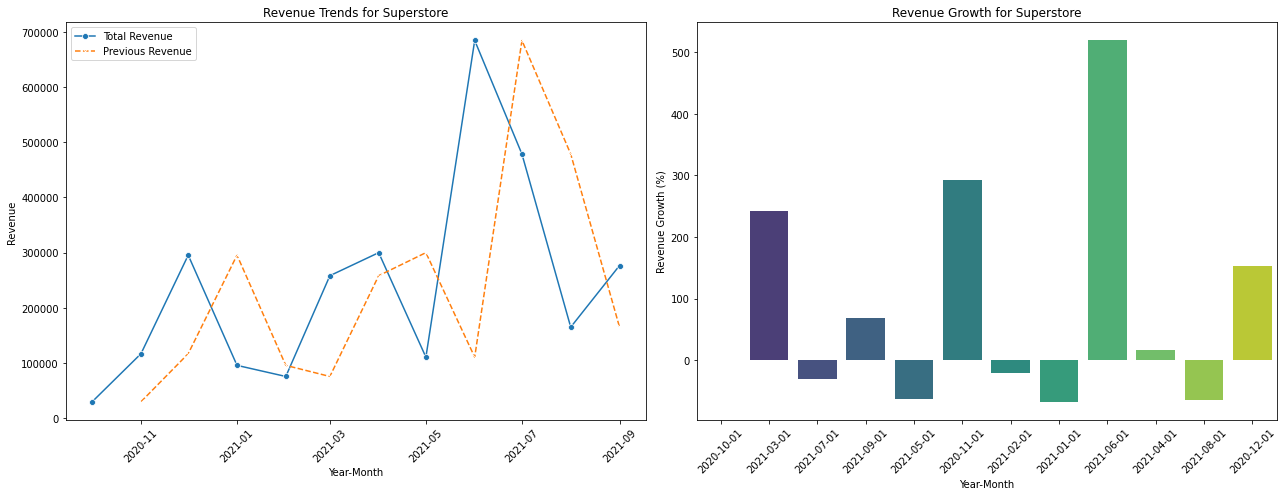

In [ ]:
plot_category('Superstore')

##### Here, we have chosen to view for a single category, Superstore. 

#### 3. Top 5 categories having a maximum number of orders and maximum number of cancellations in the month.

In [ ]:
df = spark.read.table("curated.categorybyorders")

In [ ]:
# Convert to pandas DataFrame
grouped_pd = df.toPandas()

print(grouped_pd["Year_Month"].unique())

['2021-04' '2020-12' '2021-06' '2021-03' '2021-01' '2020-11' '2021-07'
 '2021-09' '2021-05' '2021-02' '2021-08' '2020-10']


In [ ]:
def plot_top_categories(df, selected_month):
    # Filter data for the selected month
    filtered_df = df[df['Year_Month'] == selected_month]

    # Check if filtered_df is empty
    if filtered_df.empty:
        print(f"No data available for month: {selected_month}")
        return

    # Aggregate data to get the total number of orders and cancellations per category for the selected month
    aggregated_df = filtered_df.groupby('Category').agg({
        'Total_Order': 'sum',
        'Total_Cancellations': 'sum'
    }).reset_index()

    # Get top 5 categories by total number of orders and cancellations
    top_orders = aggregated_df.nlargest(5, 'Total_Order')
    top_cancellations = aggregated_df.nlargest(5, 'Total_Cancellations')

    # Create subplots for stacked bar plots
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Plot for Total Orders
    sns.barplot(data=top_orders, x='Total_Order', y='Category', ax=ax[0], palette='Blues_d')
    ax[0].set_title(f'Top 5 Categories by Total Orders ({selected_month})')
    ax[0].set_xlabel('Total Orders')
    ax[0].set_ylabel('Category')

    # Plot for Total Cancellations
    sns.barplot(data=top_cancellations, x='Total_Cancellations', y='Category', ax=ax[1], palette='Reds_d')
    ax[1].set_title(f'Top 5 Categories by Total Cancellations ({selected_month})')
    ax[1].set_xlabel('Total Cancellations')
    ax[1].set_ylabel('Category')

    # Adjust layout
    plt.tight_layout()
    plt.show()


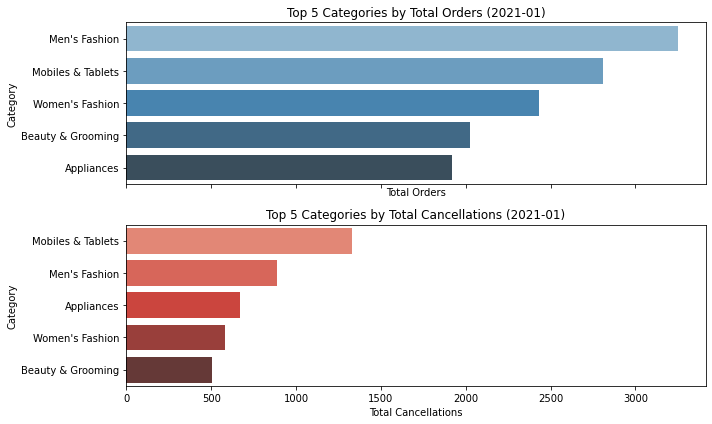

In [ ]:
plot_top_categories(grouped_pd, '2021-01')

##### Here, we have chosen to view for a single Month, 2021-01. 

#### 4. Segment customers by age: 0-20 as young, 20-35 adults, 35-55 middle-ages and >55 Old. Find the total spend (in percentage of total spend of categories) by customers by different age segments by different categories until this month i.e. including all previous and current month.

In [ ]:
df = spark.read.table("curated.spendbyage")

In [ ]:
from pyspark.sql import functions as F
# Create the crosstab (pivot) with Category as rows and Age_Segment as columns
crosstab_df = df.groupBy("Category").pivot("Age_Segment").agg(F.mean("Spend_Percentage"))

##### Creating a crosstab

In [ ]:
crosstab_df.show()

+------------------+------+-----------+------+------+
|          Category| Adult|Middle-aged|   Old| Young|
+------------------+------+-----------+------+------+
|School & Education|41.114|     27.041|26.682| 5.164|
|       Kids & Baby|25.911|      31.44|35.417| 7.232|
|     Entertainment|26.494|     35.937|33.327| 4.242|
|         Computing|26.102|     39.472|30.236|  4.19|
| Mobiles & Tablets|25.002|     36.288|33.799| 4.911|
| Beauty & Grooming|28.444|     31.289|35.017|  5.25|
|   Health & Sports|20.362|     39.242|37.171| 3.226|
|           Soghaat|21.675|     31.978|35.036|11.311|
|             Books|22.224|     33.057| 38.63| 6.089|
|            Others|26.277|     31.398|38.164| 4.162|
|        Superstore|23.397|     37.059|35.542| 4.002|
|     Men's Fashion|25.253|      35.24|33.254| 6.253|
|        Appliances|27.883|     34.703| 32.96| 4.454|
|   Women's Fashion|25.765|     33.641|33.239| 7.355|
|     Home & Living|25.864|     32.486|36.363| 5.287|
+------------------+------+-

#### 5. Calculate the RFM values for each customer (by customer id).
For Recency calculation, used "01/10/2021" as last date. So, the recency for any customer should be how many weeks before he or she has made the last purchase from the date of 01/10/2021.

In [ ]:
df = spark.read.table("curated.RFM")

In [ ]:
# Create the crosstab
crosstab_df = (df.groupBy("Freq_Segment", "Recency_Segment")
               .pivot("Money_Segment")
               .agg(F.count("Cust_Id")))

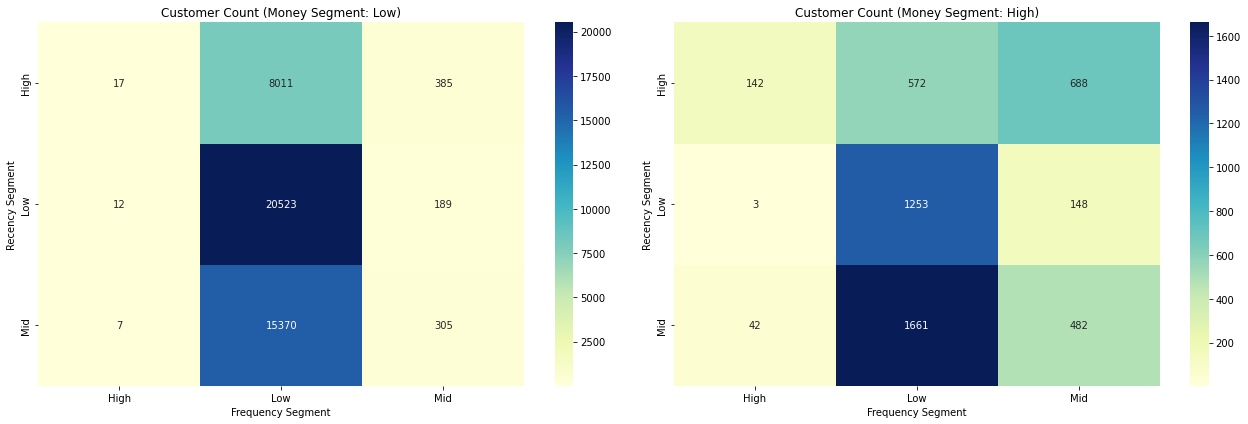

In [ ]:
pandas_df = crosstab_df.toPandas()

# List of money segments
money_segments = ['Low', 'High']

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, segment in enumerate(money_segments):
    heatmap_data = pandas_df.pivot('Recency_Segment', 'Freq_Segment', segment)
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", ax=axes[i])
    axes[i].set_title(f"Customer Count (Money Segment: {segment})")
    axes[i].set_xlabel("Frequency Segment")
    axes[i].set_ylabel("Recency Segment")

plt.tight_layout()
plt.show()

#### 6. Forecast revenue for each category based on simple exponential smoothing.

In [ ]:
df = spark.read.table("curated.revenueforecast")

In [ ]:
def plot_category_data(df,category):
    # Filter data for the chosen category
    category_df = df[df['Category'] == category]
    
    if category_df.empty:
        print(f"No data available for category: {category}")
        return
    
    # Plot Actual vs Forecasted Revenue
    plt.figure(figsize=(14, 6))
    plt.plot(category_df['Year_Month'], category_df['Revenue'], marker='o', label='Actual Revenue')
    plt.plot(category_df['Year_Month'], category_df['Forecast_Revenue'], marker='o', linestyle='--', label='Forecasted Revenue')
    plt.title(f'Actual vs Forecasted Revenue for {category}')
    plt.xlabel('Year_Month')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Percentage Error
    plt.figure(figsize=(14, 6))
    plt.bar(category_df['Year_Month'], category_df['Percentage_Error'], color='orange', label='Percentage Error')
    plt.title(f'Percentage Error in Forecasting for {category}')
    plt.xlabel('Year_Month')
    plt.ylabel('Percentage Error')
    plt.legend()
    plt.grid(True)
    plt.show()


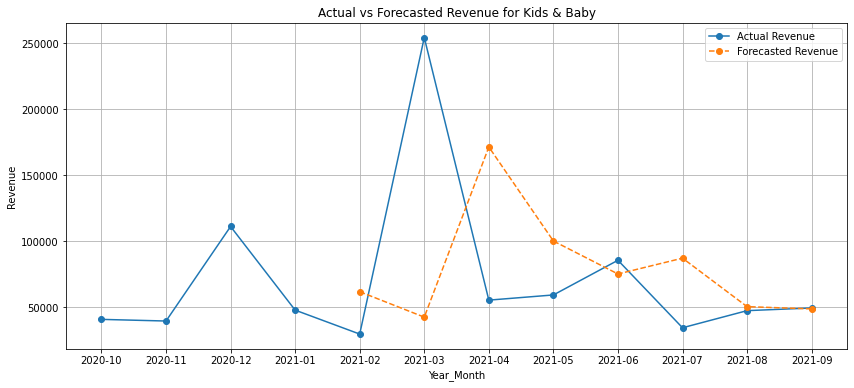

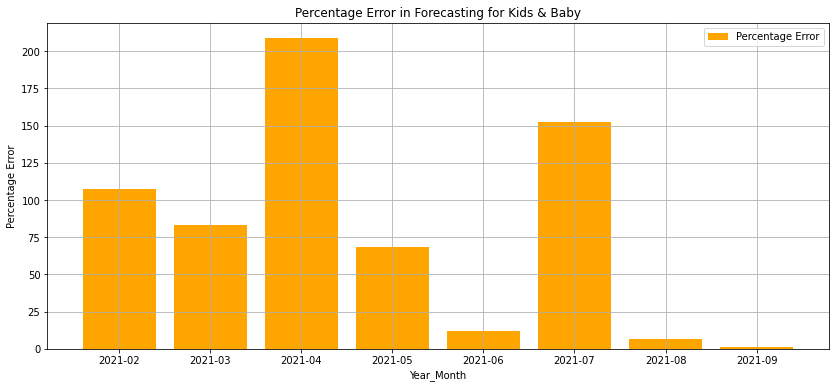

In [ ]:
plot_category_data(df, 'Kids & Baby')

##### Here, we have the forecast and error for a category, Kids & Baby

#### 7. Understanding the pattern among Payment method and Final status of orders

In [ ]:
df = spark.read.table("curated.statuscount")

+----------+--------------+----------+------------+-----------+
|  Category|Payment_Method|Year_Month|Final_Status|Order_Count|
+----------+--------------+----------+------------+-----------+
|Appliances|       Easypay|   2020-10|   cancelled|         28|
|Appliances|       Easypay|   2020-10|    received|         19|
|Appliances|       Easypay|   2020-11|    received|         49|
|Appliances|       Easypay|   2020-11|   cancelled|         93|
|Appliances|       Easypay|   2020-12|   cancelled|       3265|
+----------+--------------+----------+------------+-----------+
only showing top 5 rows



In [ ]:
def plot_order_data(df, category=None, year_month=None):
    # Filter DataFrame based on optional category and year_month
    if category:
        df = df[df['Category'] == category]
    if year_month:
        df = df[df['Year_Month'] == year_month]

    # Check for empty DataFrame after filtering
    if df.empty:
        print(f"No data available for category: {category} or year_month: {year_month}")
        return
    
    # Ensure there are numeric values to plot
    if df['Order_Count'].isnull().all():
        print("No numeric data available to plot.")
        return

    # Create the line plot
    plt.figure(figsize=(14, 7))
    try:
        sns.lineplot(data=df, x='Year_Month', y='Order_Count', hue='Payment_Method', marker='o')
        plt.title(f'Line Plot of Orders by Payment Method {"for " + category if category else ""} {"in " + year_month if year_month else ""}')
        plt.xlabel('Year_Month')
        plt.ylabel('Order_Count')
        plt.legend(title='Payment_Method')
        plt.grid(True)
        plt.show()
    except ValueError as e:
        print(f"Error while plotting line plot: {e}")

    # Create the count plot for Payment_Method vs Final_Status
    plt.figure(figsize=(14, 7))
    try:
        sns.countplot(data=df, x='Payment_Method', hue='Final_Status', palette='Set2')
        plt.title(f'Count Plot of Payment Method vs Final Status {"for " + category if category else ""} {"in " + year_month if year_month else ""}')
        plt.xlabel('Payment_Method')
        plt.ylabel('Count')
        plt.legend(title='Final_Status')
        plt.grid(True)
        plt.show()
    except ValueError as e:
        print(f"Error while plotting count plot: {e}")

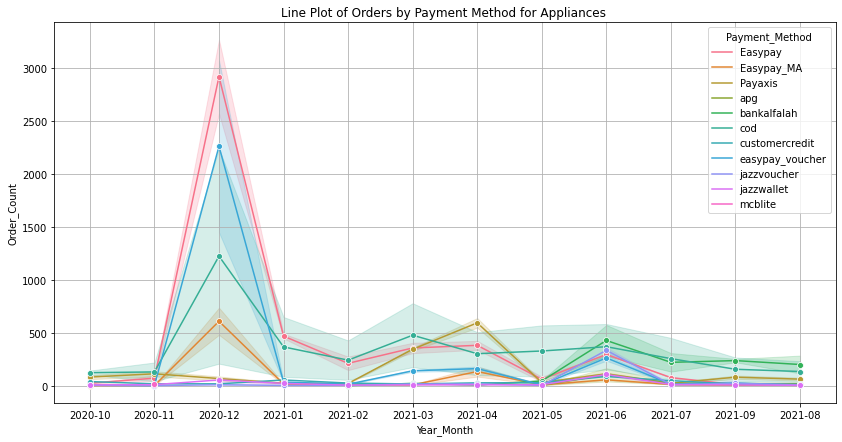

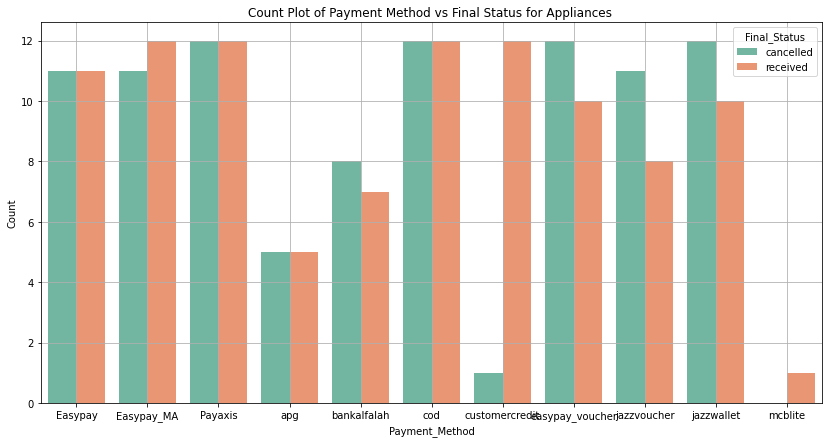

In [ ]:
# Ensure correct data types
df['Order_Count'] = pd.to_numeric(df['Order_Count'], errors='coerce')

plot_order_data(df, category='Appliances') ##, year_month='2021-01')

#### 8. Understanding the Orders based by demography and gender

In [ ]:
df = spark.read.table("curated.revbydemography")

In [ ]:
df = df.toPandas()

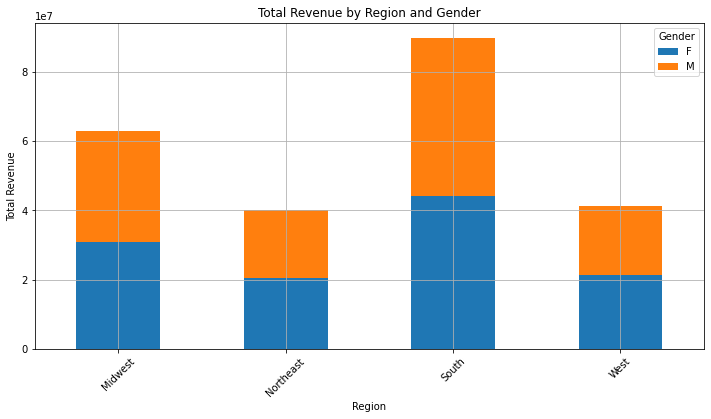

In [ ]:
# Pivot table to prepare data for stacked bar plot
pivot_df = df.pivot_table(index='Region', columns='Gender', values='total_Revenue', aggfunc='sum', fill_value=0)

# Stacked bar plot
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Total Revenue by Region and Gender')
plt.xlabel('Region')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

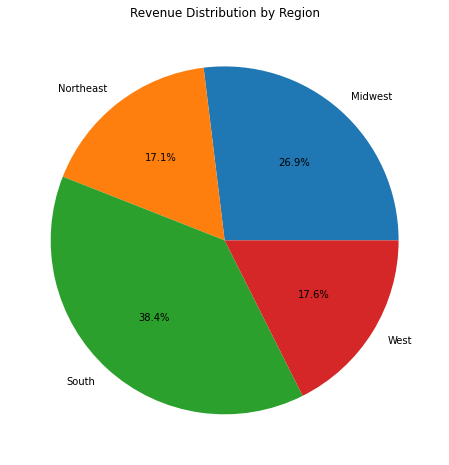

In [ ]:
# Pie chart for total revenue by Region
plt.figure(figsize=(8, 8))
df.groupby('Region')['total_Revenue'].sum().plot(kind='pie', autopct='%1.1f%%')
plt.title('Revenue Distribution by Region')
plt.ylabel('')  # Hide y-label
plt.show()